In [236]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls '/content/drive/Shared drives/lightEchoes/'

model.png  star64/


In [237]:
cd '/content/drive/Shared drives/lightEchoes/'

/content/drive/Shared drives/lightEchoes


In [238]:
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sn

import cv2
import glob

import tensorflow as tf
from tensorflow import keras

In [239]:
# plot setup
pl.rcParams['lines.linewidth'] = 1.0


### prep dataset

skip to load dataset if already saved

In [ ]:
imgfiles_nostar = glob.glob('star64/nostar/*.jpg')
imgfiles_star = glob.glob('star64/star/*.jpg')
imgfiles_LEs = glob.glob('star64/LEs/*.jpg')


In [ ]:
N = [len(imgfiles_nostar), len(imgfiles_star), len(imgfiles_LEs)]
N

[1127, 1359, 1168]

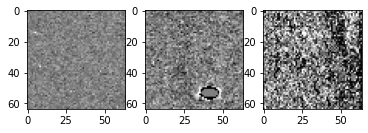

In [ ]:
# show some images
img0 = cv2.imread(imgfiles_nostar[1])
img1 = cv2.imread(imgfiles_star[1])
img2 = cv2.imread(imgfiles_LEs[1])

fig, axs = pl.subplots(nrows=1, ncols=3, )

axs[0].imshow(img0)
axs[1].imshow(img1)
axs[2].imshow(img2)


In [ ]:
img0.shape

(64, 64, 3)

In [ ]:
def stack_imgs(imgfiles, imgshape=[64, 64, 3]):
    """stack image as numpy array """
    N_imgs = len(imgfiles)
    imgarr = np.zeros([N_imgs, imgshape[0], imgshape[1], imgshape[2]], dtype=np.uint8)
    for i, imf in enumerate( imgfiles):  
        imgarr[i] = np.asarray( cv2.imread( imf ))
        print('imread ', i, '/', N_imgs,  imf)
    return imgarr


In [ ]:
# stack all images as numpy array uint8
imgs_nostar = stack_imgs(imgfiles_nostar) 
imgs_star = stack_imgs(imgfiles_star) 
imgs_LEs = stack_imgs(imgfiles_LEs) 

imread  0 / 1127 star64/nostar/23_52.jpg
imread  1 / 1127 star64/nostar/21_57.jpg
imread  2 / 1127 star64/nostar/23_136.jpg
imread  3 / 1127 star64/nostar/23_14.jpg
imread  4 / 1127 star64/nostar/20_95.jpg
imread  5 / 1127 star64/nostar/23_29.jpg
imread  6 / 1127 star64/nostar/23_61.jpg
imread  7 / 1127 star64/nostar/23_107.jpg
imread  8 / 1127 star64/nostar/25_104 (1).jpg
imread  9 / 1127 star64/nostar/25_27 (1).jpg
imread  10 / 1127 star64/nostar/25_104.jpg
imread  11 / 1127 star64/nostar/25_33 (1).jpg
imread  12 / 1127 star64/nostar/25_33.jpg
imread  13 / 1127 star64/nostar/25_105 (1).jpg
imread  14 / 1127 star64/nostar/25_105.jpg
imread  15 / 1127 star64/nostar/25_27.jpg
imread  16 / 1127 star64/nostar/31_39 (1).jpg
imread  17 / 1127 star64/nostar/31_39.jpg
imread  18 / 1127 star64/nostar/32_92 (1).jpg
imread  19 / 1127 star64/nostar/31_38 (1).jpg
imread  20 / 1127 star64/nostar/31_38.jpg
imread  21 / 1127 star64/nostar/32_13 (1).jpg
imread  22 / 1127 star64/nostar/32_13.jpg
imread

In [ ]:
imgs_nostar.shape, imgs_star.shape, imgs_LEs.shape

((1127, 64, 64, 3), (1359, 64, 64, 3), (1168, 64, 64, 3))

Text(0.5, 1.0, 'light echo')

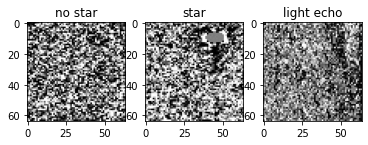

In [ ]:
# show some images
fig, axs = pl.subplots(nrows=1, ncols=3, )

axs[0].imshow(imgs_nostar[3, :])
axs[0].set_title('no star')
axs[1].imshow(imgs_star[3, :])
axs[1].set_title('star')

axs[2].imshow(imgs_LEs[3, :])
axs[2].set_title('light echo')


In [ ]:
# create labels
# nostar 0, star 1, light echo 2

y_nostar = np.zeros( (N[0], 1) )
y_star = np.ones( (N[1], 1) ) 
y_LEs = np.ones( (N[2], 1) ) * 2

In [ ]:
X = np.concatenate( (imgs_nostar, imgs_star, imgs_LEs),  axis=0 ) [:,:,:,0] # select the first channel only
X.shape

(3654, 64, 64)

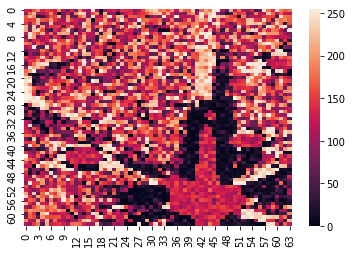

In [ ]:
sn.heatmap(X[1400,:, :])

In [ ]:
Y = np.concatenate( (y_nostar, y_star, y_LEs),  axis=0 )
Y.shape

(3654, 1)

### load data

In [240]:
# save X, Y to npz
# np.savez('./star64/imgsXY3654.npz', X=X, Y=Y)

imgsXY = np.load('./star64/imgsXY3654.npz')
X = imgsXY['X']
Y = imgsXY['Y']

split train and test

In [241]:
# shuffle and split 
from sklearn.model_selection import train_test_split

Xn = X / 255.  # normalize 
X_train, X_test, y_train, y_test = train_test_split(Xn, Y, test_size=0.33, shuffle=True, random_state=42)

# create a validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, shuffle=True, random_state=43)



In [ ]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((1640, 64, 64), (1640, 1)),
 ((808, 64, 64), (808, 1)),
 ((1206, 64, 64), (1206, 1)))

In [ ]:
np.unique(y_train, return_counts=True)

(array([0., 1., 2.]), array([485, 609, 546]))

In [242]:
# one hot encoding the labels
y_train_onehot = keras.utils.to_categorical(y_train)
y_val_onehot = keras.utils.to_categorical(y_val)
y_test_onehot = keras.utils.to_categorical(y_test)


In [ ]:
y_train_onehot.shape, y_val_onehot.shape, y_test_onehot.shape, 

((1640, 3), (808, 3), (1206, 3))

In [8]:
y_train_onehot[0, :]

array([0., 1., 0.], dtype=float32)

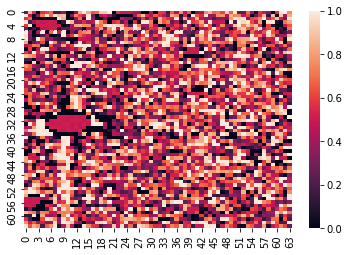

In [9]:
sn.heatmap(X_train[0, :, :])

### Building models

#### utils

In [243]:
from sklearn.metrics import confusion_matrix

def plot_cm(model, X_test=X_test, y_test=y_test):
    
    y_test_pred = model.predict( X_test )
    y_test_argmax = np.argmax( y_test_pred, axis=1)
    cm = confusion_matrix(y_pred=y_test_argmax, y_true=y_test, ) 

    sn.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
           xticklabels=['nostar_pred', 'star_pred', 'light echo_pred'], 
           yticklabels=['nostar', 'star', 'light echo'])

def plot_score(history):
    '''plot loss from keras fit history output'''
    df_history = pd.DataFrame(history.history)
    #pl.style.use('seaborn')

    pl.plot(df_history.loss, '.-', label='loss')
    pl.plot(df_history.accuracy, '*-', label='accuracy')

    if 'val_loss' in df_history.columns:
        pl.plot(df_history.val_loss, '.-', label='val_loss')
        pl.plot(df_history.val_accuracy, '*-', label='val_accuracy')

    pl.xlabel('epoch')
    pl.ylabel('score')
    pl.legend()

def plot_filters(model, layer = 1 ):
    layer_n = model.layers[layer]
    filters, bias = layer_n.get_weights()  # all filters used in layers

    n_filter = filters.shape[3]
    col = int( n_filter / 2)
    fig, axs = pl.subplots(nrows=2, ncols=col, figsize=(24, 8) )
    axs = axs.ravel()
    for i in range( n_filter ):
        axs[i].imshow( filters [:,:,0, i], cmap='gray')
        axs[i].axis('on')
    fig.suptitle('filters {} {}'.format(layer, filters.shape) )

def plot_features(layer = 1):
    
    n_filter = features[layer].shape[3]
    col = int( n_filter / 2)
    fig, axs = pl.subplots(nrows=2, ncols=col, figsize=(24, 8) )
    axs = axs.ravel()
    for i in range( n_filter ):
        axs[i].imshow( features[layer].numpy() [0,:,:, i], cmap='gray')
        axs[i].axis('off')
    fig.suptitle('feature map {} {}'.format(layer,features[layer].shape) )


#### simple neural network

In [ ]:
model = keras.Sequential([keras.layers.Flatten(input_shape=(64, 64, 1)),
                         #keras.layers.Dense(1024, activation=tf.nn.relu),  
                         # keras.layers.Dense(256, activation=tf.nn.relu),
                         #keras.layers.Dense(512, activation=tf.nn.relu), 
                         keras.layers.Dense(256, activation=tf.nn.relu), 
                         keras.layers.Dense(128, activation=tf.nn.relu), 
                         keras.layers.Dense(64, activation=tf.nn.relu), 
                         keras.layers.Dense(32, activation=tf.nn.relu),
                         keras.layers.Dense(16, activation=tf.nn.relu),
                         keras.layers.Dense(8, activation=tf.nn.relu),
                         keras.layers.Dense(3, activation=tf.nn.sigmoid) ])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


In [ ]:
X_train.shape

(990, 64, 64, 3)

In [ ]:
history = model.fit(X_train[:,:,:,1].reshape(X_train.shape[0], 64, 64, 1), y_train_onehot, epochs=15)


Epoch 1/15
31/31 [==============================] - 0s 5ms/step - loss: 1.0993 - accuracy: 0.3434
Epoch 2/15
31/31 [==============================] - 0s 4ms/step - loss: 1.0938 - accuracy: 0.3434
Epoch 3/15
31/31 [==============================] - 0s 4ms/step - loss: 1.0854 - accuracy: 0.3758
Epoch 4/15
31/31 [==============================] - 0s 5ms/step - loss: 1.0674 - accuracy: 0.4414
Epoch 5/15
31/31 [==============================] - 0s 4ms/step - loss: 1.0515 - accuracy: 0.4657
Epoch 6/15
31/31 [==============================] - 0s 5ms/step - loss: 1.0159 - accuracy: 0.4707
Epoch 7/15
31/31 [==============================] - 0s 5ms/step - loss: 0.9506 - accuracy: 0.5525
Epoch 8/15
31/31 [==============================] - 0s 4ms/step - loss: 0.9055 - accuracy: 0.5556
Epoch 9/15
31/31 [==============================] - 0s 4ms/step - loss: 0.8358 - accuracy: 0.6222
Epoch 10/15
31/31 [==============================] - 0s 5ms/step - loss: 0.7688 - accuracy: 0.6313
Epoch 11/15
31/31 [

In [ ]:
df_history = pd.DataFrame(history.history)
df_history

loss  accuracy
0   1.099313  0.343434
1   1.093790  0.343434
2   1.085382  0.375758
3   1.067410  0.441414
4   1.051470  0.465657
5   1.015948  0.470707
6   0.950641  0.552525
7   0.905505  0.555556
8   0.835831  0.622222
9   0.768786  0.631313
10  0.704772  0.680808
11  0.693693  0.672727
12  0.631377  0.757576
13  0.587979  0.840404
14  0.493182  0.881818

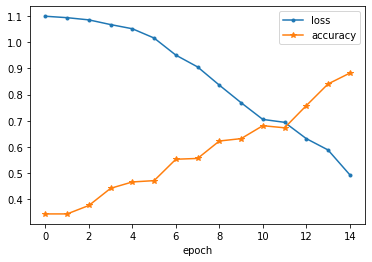

In [ ]:
pl.plot(df_history.loss, '.-', label='loss')
pl.plot(df_history.accuracy, '*-', label='accuracy')
pl.xlabel('epoch')
pl.legend()

In [ ]:
np.unique( y_test, return_counts=True )

(array([0., 1., 2.]), array([167, 178, 144]))

In [ ]:
# evaulate model
test_loss, test_acc = model.evaluate(X_test[:,:,:,1].reshape( X_test.shape[0], 64, 64, 1 ), y_test_onehot)


16/16 [==============================] - 0s 3ms/step - loss: 1.1502 - accuracy: 0.4315


#### Convolutional 2D model, filter size=3

In [244]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


In [245]:
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)
X_val = X_val.reshape(X_val.shape[0], 64, 64, 1)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 1)


In [270]:
def create_model(kernel_size=3, input_shape=(64,64,1)):
    #create model
    model_cnn = keras.Sequential()
    #add model layers
    model_cnn.add( keras.Input(shape=input_shape) )
    #model_cnn.add(Conv2D(8, kernel_size=kernel_size, padding='same', activation='relu'))
    #model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    #model_cnn.add( Dropout(0.2) )

    model_cnn.add(Conv2D(16, kernel_size=kernel_size, padding='same', activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add( Dropout(0.2) )

    model_cnn.add(Conv2D(32, kernel_size=kernel_size, padding='same', activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add( Dropout(0.2) )

    model_cnn.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add( Dropout(0.2) )

    model_cnn.add(Flatten())
    model_cnn.add( Dropout(0.5) )
    #model_cnn.add(Dense(units = 16, activation = 'relu'))
    model_cnn.add(Dense(3, activation='softmax'))

    model_cnn.summary() 
    return model_cnn


In [274]:
model_cnn_k3 = create_model(kernel_size=3)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 64)      

In [ ]:
# keras.utils.plot_model(model_cnn_k3, show_shapes=True, rankdir='TB')

In [275]:
model_cnn_k3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


In [276]:
history_cnn_k3 = model_cnn_k3.fit(X_train, y_train_onehot, epochs=100, validation_data=(X_val, y_val_onehot))


Epoch 1/100
52/52 [==============================] - 0s 8ms/step - loss: 1.1183 - accuracy: 0.3409 - val_loss: 1.0962 - val_accuracy: 0.3886
Epoch 2/100
52/52 [==============================] - 0s 6ms/step - loss: 1.0954 - accuracy: 0.3622 - val_loss: 1.0966 - val_accuracy: 0.3787
Epoch 3/100
52/52 [==============================] - 0s 5ms/step - loss: 1.0949 - accuracy: 0.3689 - val_loss: 1.0951 - val_accuracy: 0.3465
Epoch 4/100
52/52 [==============================] - 0s 6ms/step - loss: 1.0931 - accuracy: 0.3573 - val_loss: 1.0935 - val_accuracy: 0.3899
Epoch 5/100
52/52 [==============================] - 0s 6ms/step - loss: 1.0856 - accuracy: 0.3799 - val_loss: 1.0820 - val_accuracy: 0.4356
Epoch 6/100
52/52 [==============================] - 0s 6ms/step - loss: 1.0520 - accuracy: 0.4128 - val_loss: 0.9905 - val_accuracy: 0.5817
Epoch 7/100
52/52 [==============================] - 0s 6ms/step - loss: 0.9412 - accuracy: 0.5482 - val_loss: 0.8558 - val_accuracy: 0.5978
Epoch 8/100
5

In [277]:
# evaulate model
test_loss, test_acc = model_cnn_k3.evaluate(X_test, y_test_onehot)


38/38 [==============================] - 0s 3ms/step - loss: 0.0275 - accuracy: 0.9950


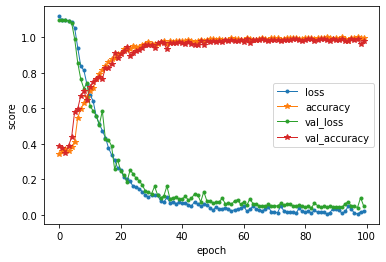

In [293]:
plot_score(history_cnn_k3)

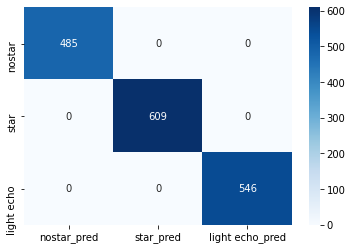

In [294]:
plot_cm(model_cnn_k3, X_train, y_train)

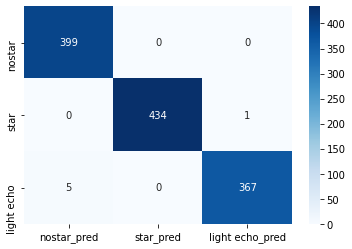

In [295]:
plot_cm(model_cnn_k3, X_test, y_test)

In [32]:
y_test.shape

(1206, 1)

In [332]:
# get false positive 
y_pred_prob = model_cnn_k3.predict(X_test)
y_pred = np.argmax( y_pred_prob, axis=1)
y_pred_prob = np.max( y_pred_prob, axis=1)


In [362]:
np.where( (y_pred == 2) & (y_test[:,0] == 1) )

(array([964]),)

In [364]:
y_test[964].item(), y_pred[964]

(1.0, 2)

Text(0.5, 1.0, 'y: 1.0 , y_pred: 2-0.98')

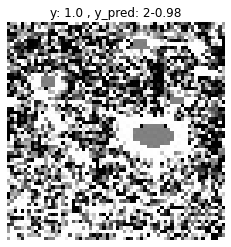

In [363]:
idx_fp = np.where( (y_pred == 2) & (y_test[:,0] == 1) )[0]
idx = idx_fp[0]
pl.imshow(X_test[ idx, :,:,0], cmap='gray')
pl.axis('off')
title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
pl.title(title)

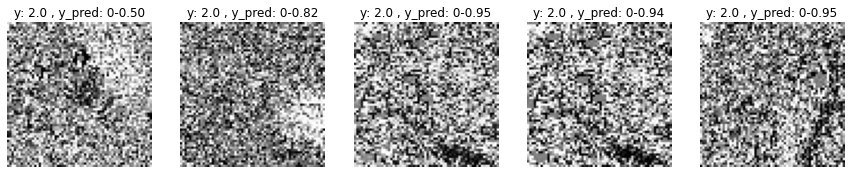

In [356]:
idx_fp = np.where( (y_pred == 0) & (y_test[:,0] == 2) )[0]
col = len(idx_fp)
fig, axs = pl.subplots(nrows=1, ncols=col, figsize=(15, 8))
axs = axs.ravel()
for i in range(col):
    idx = idx_fp[i]
    axs[i].imshow(X_test[ idx, :,:,0], cmap='gray')
    axs[i].axis('off')
    title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
    axs[i].set_title(title)


explore model weight

In [ ]:
plot_filters(model_cnn_k3, 0)
plot_filters(model_cnn_k3, 3)
plot_filters(model_cnn_k3, 6)


In [258]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 1))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25 
    #return (img - 0.5) * 0.25 + 0.125 # scale to [0, 0.25]

def compute_loss(feature_extractor, input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(feature_extractor, img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(feature_extractor, img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


In [253]:

def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img


In [259]:
def get_filterimg(feature_extractor, filter_index=0, iterations=30, learning_rate=10.0):
    # We run gradient ascent for 20 steps
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(feature_extractor, img, filter_index, learning_rate)
    #print( loss.numpy() )
    
    imgarr = img[0].numpy()
    # Center crop
    imgarr = imgarr[10:-10, 10:-10, :]

    # Clip to [0, 1]
    imgarr += 0.5
    imgarr = np.clip(imgarr, 0, 1)
    return imgarr

In [265]:
def plot_filterimg(model, layer_name, it=50, lr=10):

    layer = model.get_layer(name=layer_name)
    feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

    img_width = 64
    img_height = 64

    n_filter = layer.weights[0].numpy().shape[-1]
    # n_filter = 64
    nrow = 4
    ncol = int( np.ceil( n_filter/nrow) )
    fig, axs = pl.subplots(nrows=nrow, ncols=ncol )
    axs = axs.ravel()
    for i in range( n_filter ):
        # print('filter ', i)
        imgarr = get_filterimg(feature_extractor, filter_index=i, iterations=it, learning_rate=lr)
        axs[i].imshow( imgarr[:,:,0], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(i)

In [64]:
#from IPython.display import Image, display

#loss, img = visualize_filter(0)
#keras.preprocessing.image.save_img("0.png", img)


In [278]:
model_cnn_k3.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 64)      

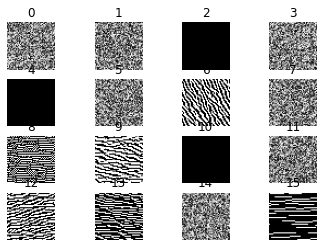

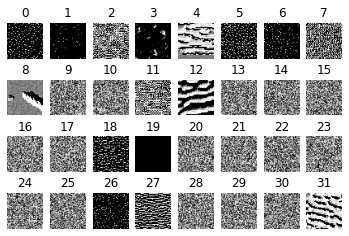

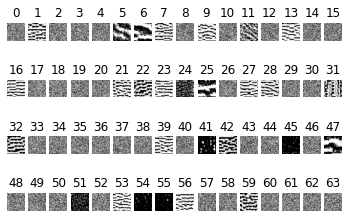

In [283]:
layer_names = ['conv2d_35', 'conv2d_36', 'conv2d_37']
for layer_name in layer_names:
    plot_filterimg(model_cnn_k3, layer_name, it=50, lr=10);

extract features

In [365]:
extractor = keras.Model(inputs=model_cnn_k3.inputs,
                        outputs=[layer.output for layer in model_cnn_k3.layers])


In [286]:
X.shape

(3654, 64, 64)

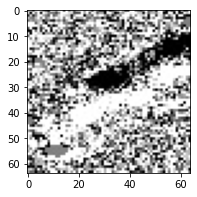

In [366]:
imgidx = 3520
img_ = X[imgidx, :, :]/255
pl.figure(figsize=(3,3))
pl.imshow(img_, cmap='gray')


In [367]:
Y[imgidx]

array([2.])

In [289]:
# predicted
np.argmax( model_cnn_k3.predict(img_.reshape(1, 64, 64, 1)) )

2

In [368]:
features = extractor(img_.reshape(1, 64, 64, 1 ))


In [291]:
for i in range( len(features) ):
    print(i, features[i].numpy().shape)

0 (1, 64, 64, 16)
1 (1, 32, 32, 16)
2 (1, 32, 32, 16)
3 (1, 32, 32, 32)
4 (1, 16, 16, 32)
5 (1, 16, 16, 32)
6 (1, 16, 16, 64)
7 (1, 8, 8, 64)
8 (1, 8, 8, 64)
9 (1, 4096)
10 (1, 4096)
11 (1, 3)


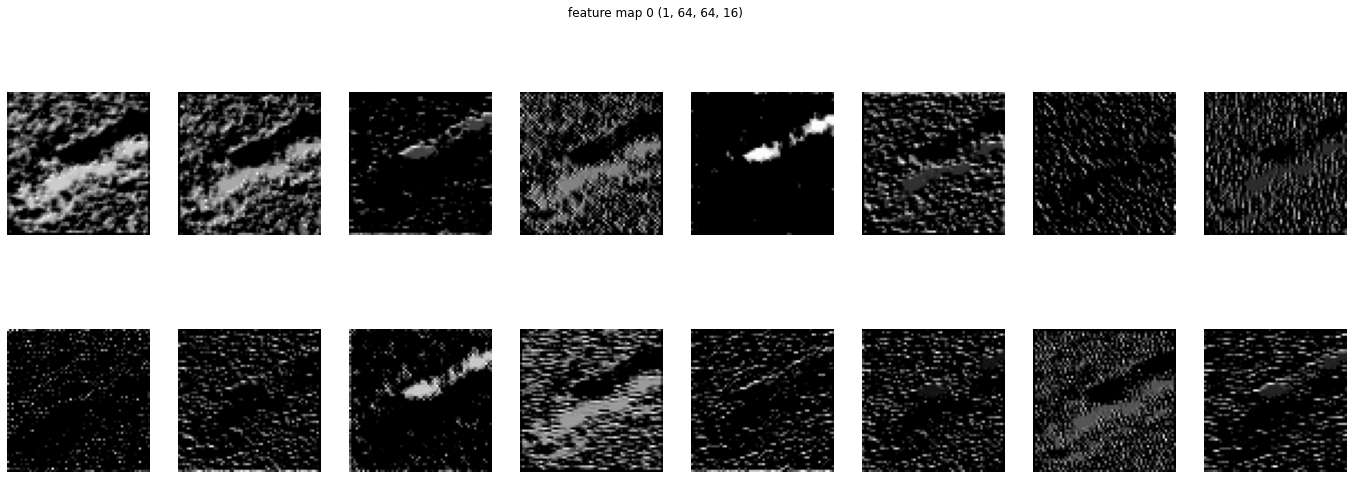

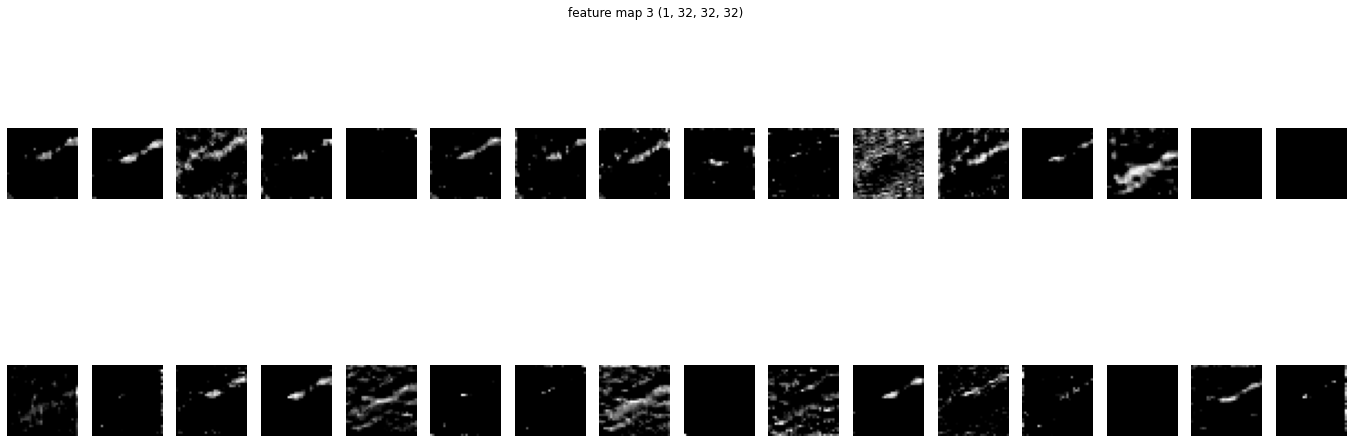

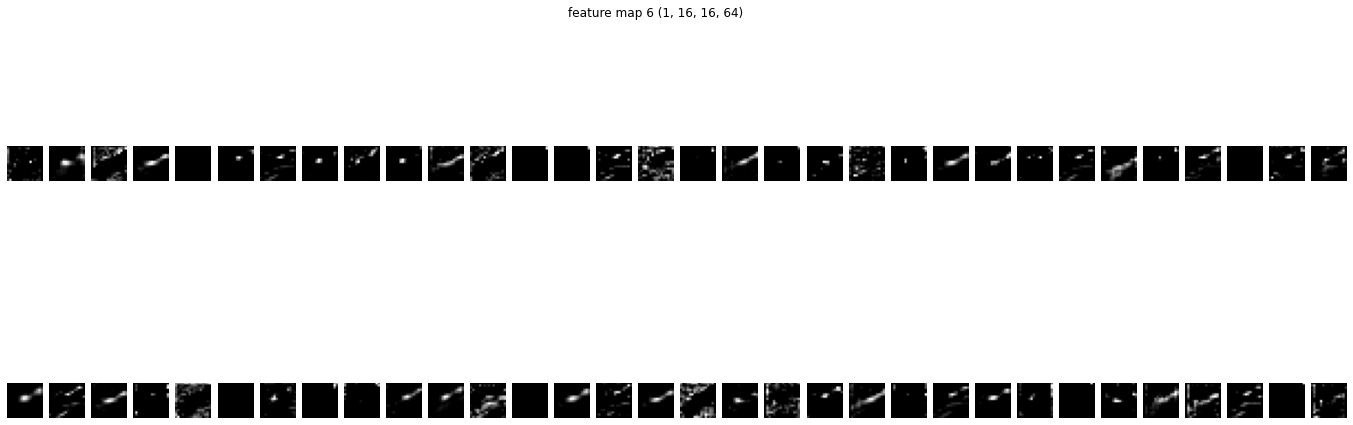

In [369]:
plot_features(layer=0)
plot_features(layer=3)
plot_features(layer=6)


#### Convolutional 2D model , filter size=6

In [370]:
model_cnn_k6 = create_model(kernel_size=6)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 64, 64, 16)        592       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 64)      

In [ ]:
# keras.utils.plot_model(model_cnn, show_shapes=True, rankdir='TB')

In [371]:
model_cnn_k6.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


In [ ]:
history_cnn_k6 = model_cnn_k6.fit(X_train, y_train_onehot, epochs=100, validation_data=(X_val, y_val_onehot))


In [373]:
# evaulate model
test_loss, test_acc = model_cnn_k6.evaluate(X_test, y_test_onehot)


38/38 [==============================] - 0s 3ms/step - loss: 0.0666 - accuracy: 0.9826


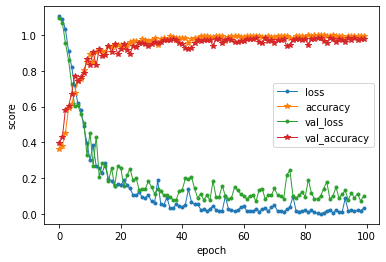

In [374]:
plot_score(history_cnn_k6)

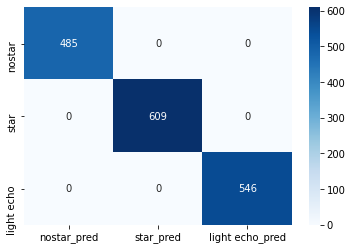

In [375]:
plot_cm(model_cnn_k6, X_train, y_train)

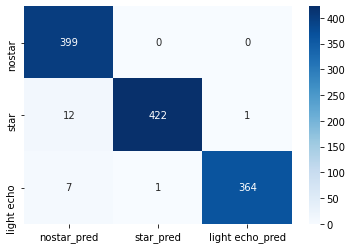

In [376]:
plot_cm(model_cnn_k6, X_test, y_test)

In [387]:
# get false positive 
y_pred_prob = model_cnn_k6.predict(X_test)
y_pred = np.argmax( y_pred_prob, axis=1)
y_pred_prob = np.max( y_pred_prob, axis=1)


Text(0.5, 1.0, 'y: 1.0 , y_pred: 2-1.00')

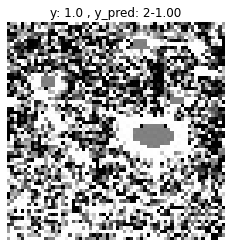

In [397]:
idx_fp = np.where( (y_pred == 2) & (y_test[:,0] == 1) )[0]
idx = idx_fp[0]
pl.imshow(X_test[ idx, :,:,0], cmap='gray')
pl.axis('off')
title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
pl.title(title)

Text(0.5, 1.0, 'y: 2.0 , y_pred: 1-0.89')

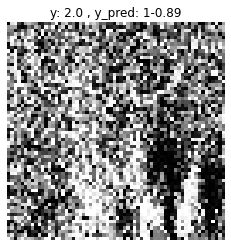

In [396]:
idx_fp = np.where( (y_pred == 1) & (y_test[:,0] == 2) )[0]
idx = idx_fp[0]
pl.imshow(X_test[ idx, :,:,0], cmap='gray')
pl.axis('off')
title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
pl.title(title)

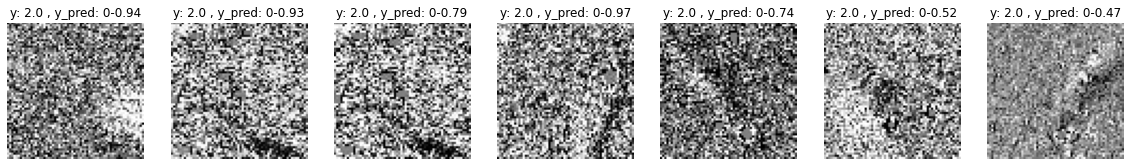

In [395]:
idx_fp = np.where( (y_pred == 0) & (y_test[:,0] == 2) )[0]
col = int( len(idx_fp) )
fig, axs = pl.subplots(nrows=1, ncols=col, figsize=(20, 8))
axs = axs.ravel()
for i in range( len(axs) ):
    idx = idx_fp[i]
    axs[i].imshow(X_test[ idx, :,:,0], cmap='gray')
    axs[i].axis('off')
    title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
    axs[i].set_title(title)

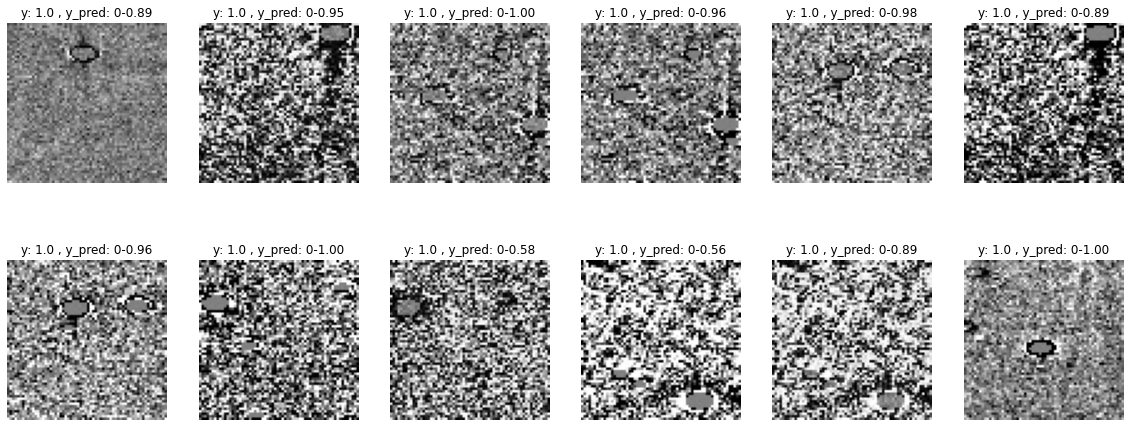

In [392]:
idx_fp = np.where( (y_pred == 0) & (y_test[:,0] == 1) )[0]
col = int( len(idx_fp) / 2 )
fig, axs = pl.subplots(nrows=2, ncols=col, figsize=(20, 8))
axs = axs.ravel()
for i in range( len(axs) ):
    idx = idx_fp[i]
    axs[i].imshow(X_test[ idx, :,:,0], cmap='gray')
    axs[i].axis('off')
    title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
    axs[i].set_title(title)

explore model weight

In [ ]:
plot_filters(model_cnn_k6, 0)
plot_filters(model_cnn_k6, 3)
plot_filters(model_cnn_k6, 6)


In [379]:
model_cnn_k6.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 64, 64, 16)        592       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 64)      

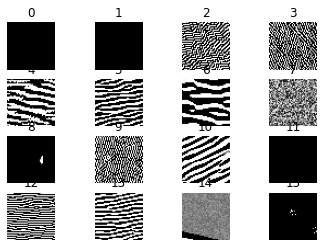

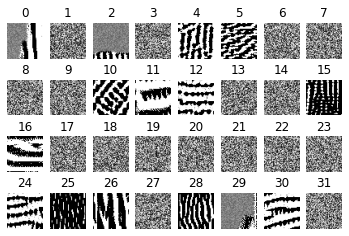

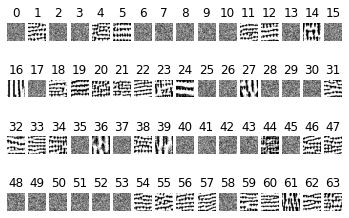

In [380]:
layer_names = ['conv2d_38', 'conv2d_39', 'conv2d_40']
for layer_name in layer_names:
    plot_filterimg(model_cnn_k6, layer_name, it=50, lr=10);

extract features

In [398]:
extractor = keras.Model(inputs=model_cnn_k6.inputs,
                        outputs=[layer.output for layer in model_cnn_k6.layers])


In [ ]:
X.shape

(3654, 64, 64)

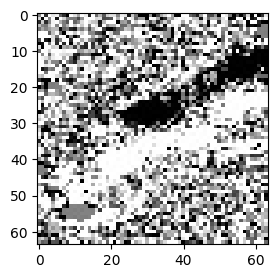

In [ ]:
imgidx = 3520
img_ = X[imgidx, :, :]/255
pl.figure(figsize=(3,3))
pl.imshow(img_, cmap='gray')


In [ ]:
Y[imgidx]

array([2.])

In [ ]:
# predicted
np.argmax( model_cnn.predict(img_.reshape(1, 64, 64, 1)) )

2

In [399]:
features = extractor(img_.reshape(1, 64, 64, 1 ))


In [ ]:
for i in range( len(features) ):
    print(i, features[i].numpy().shape)

0 (1, 64, 64, 8)
1 (1, 32, 32, 8)
2 (1, 32, 32, 8)
3 (1, 32, 32, 16)
4 (1, 16, 16, 16)
5 (1, 16, 16, 16)
6 (1, 16, 16, 32)
7 (1, 8, 8, 32)
8 (1, 8, 8, 32)
9 (1, 8, 8, 64)
10 (1, 4, 4, 64)
11 (1, 4, 4, 64)
12 (1, 1024)
13 (1, 16)
14 (1, 3)


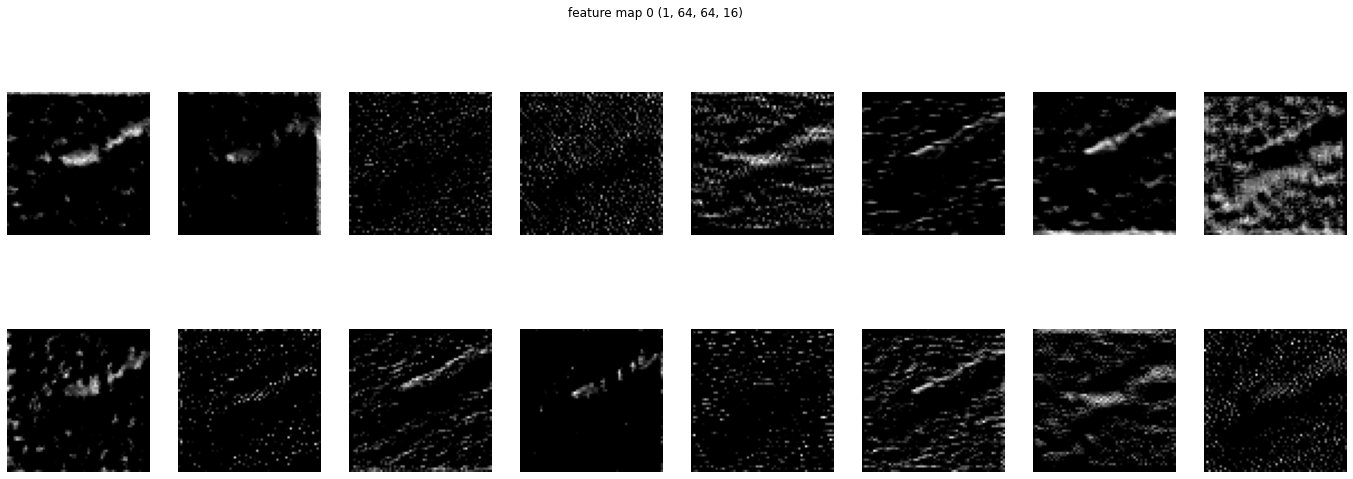

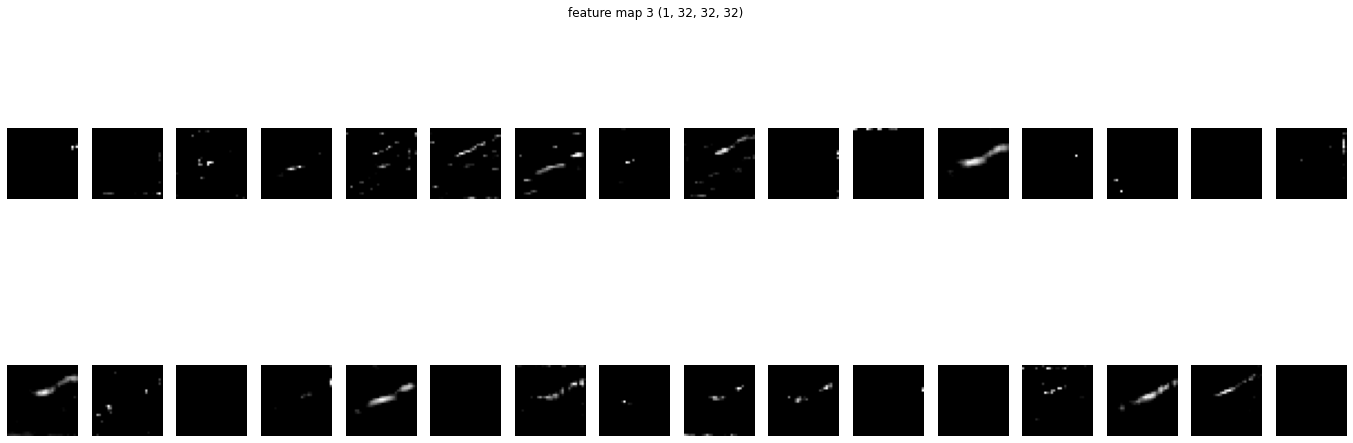

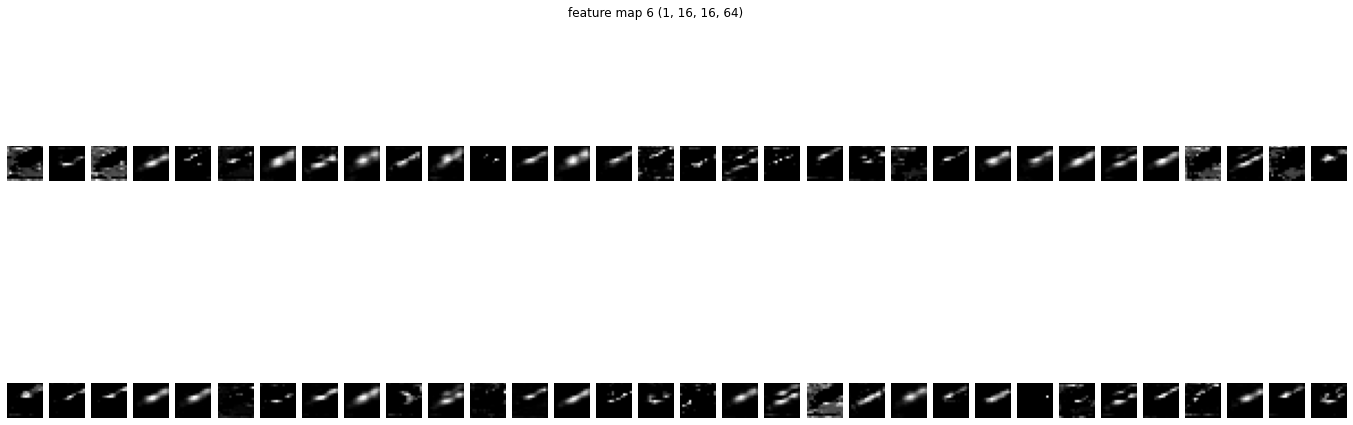

In [385]:
plot_features(layer=0)
plot_features(layer=3)
plot_features(layer=6)


#### Convolutional 2D model , filter size=9

In [400]:
model_cnn_k9 = create_model(kernel_size=9)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 64, 64, 16)        1312      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 32)        41504     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 64)      

In [ ]:
# keras.utils.plot_model(model_cnn, show_shapes=True, rankdir='TB')

In [401]:
model_cnn_k9.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


In [402]:
history_cnn_k9 = model_cnn_k9.fit(X_train, y_train_onehot, epochs=100, validation_data=(X_val, y_val_onehot))


Epoch 1/100
52/52 [==============================] - 0s 10ms/step - loss: 1.1042 - accuracy: 0.3567 - val_loss: 1.0952 - val_accuracy: 0.3193
Epoch 2/100
52/52 [==============================] - 0s 7ms/step - loss: 1.0856 - accuracy: 0.3628 - val_loss: 1.0503 - val_accuracy: 0.3911
Epoch 3/100
52/52 [==============================] - 0s 7ms/step - loss: 0.9959 - accuracy: 0.4695 - val_loss: 0.8834 - val_accuracy: 0.5965
Epoch 4/100
52/52 [==============================] - 0s 7ms/step - loss: 0.8942 - accuracy: 0.5677 - val_loss: 0.8475 - val_accuracy: 0.6473
Epoch 5/100
52/52 [==============================] - 0s 7ms/step - loss: 0.8389 - accuracy: 0.6006 - val_loss: 0.7190 - val_accuracy: 0.6856
Epoch 6/100
52/52 [==============================] - 0s 7ms/step - loss: 0.7650 - accuracy: 0.6604 - val_loss: 0.7614 - val_accuracy: 0.6621
Epoch 7/100
52/52 [==============================] - 0s 7ms/step - loss: 0.7258 - accuracy: 0.6720 - val_loss: 0.6740 - val_accuracy: 0.7302
Epoch 8/100


In [403]:
# evaulate model
test_loss, test_acc = model_cnn_k9.evaluate(X_test, y_test_onehot)


38/38 [==============================] - 0s 3ms/step - loss: 0.1528 - accuracy: 0.9677


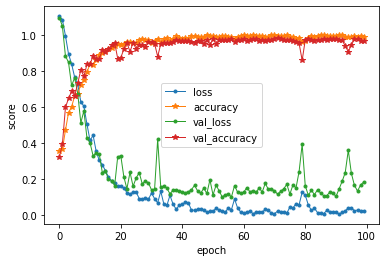

In [404]:
plot_score(history_cnn_k9)

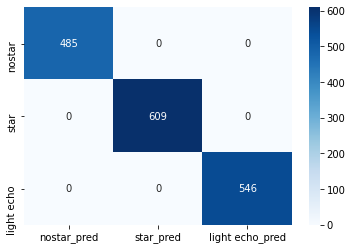

In [406]:
plot_cm(model_cnn_k9, X_train, y_train)

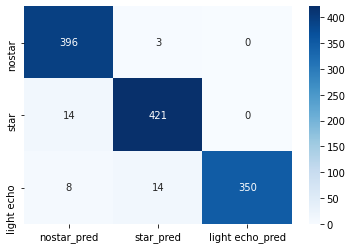

In [408]:
plot_cm(model_cnn_k9, X_test, y_test)

In [409]:
# get false positive 
y_pred_prob = model_cnn_k9.predict(X_test)
y_pred = np.argmax( y_pred_prob, axis=1)
y_pred_prob = np.max( y_pred_prob, axis=1)


Text(0.5, 1.0, 'y: 1.0 , y_pred: 2-1.00')

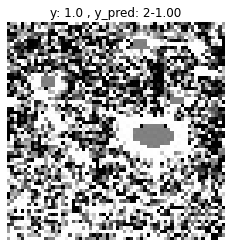

In [ ]:
idx_fp = np.where( (y_pred == 2) & (y_test[:,0] == 1) )[0]
idx = idx_fp[0]
pl.imshow(X_test[ idx, :,:,0], cmap='gray')
pl.axis('off')
title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
pl.title(title)

Text(0.5, 1.0, 'y: 2.0 , y_pred: 1-0.89')

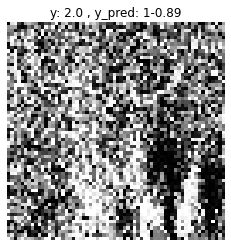

In [ ]:
idx_fp = np.where( (y_pred == 1) & (y_test[:,0] == 2) )[0]
idx = idx_fp[0]
pl.imshow(X_test[ idx, :,:,0], cmap='gray')
pl.axis('off')
title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
pl.title(title)

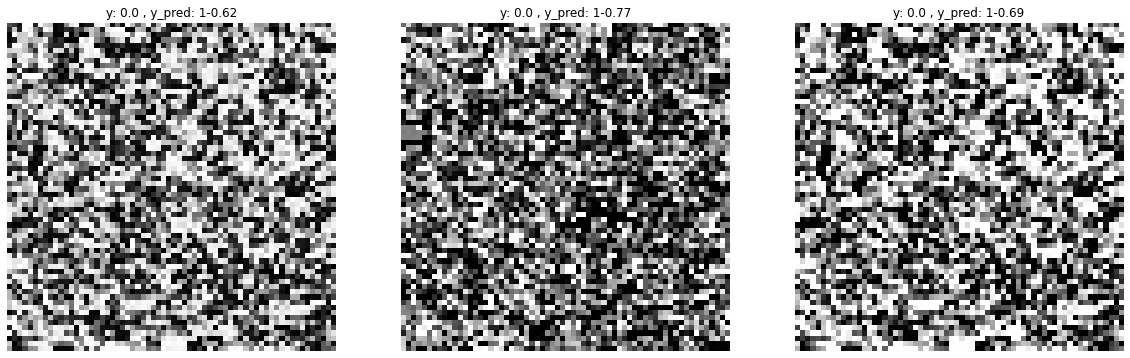

In [410]:
idx_fp = np.where( (y_pred == 1) & (y_test[:,0] == 0) )[0]
col = int( len(idx_fp) )
fig, axs = pl.subplots(nrows=1, ncols=col, figsize=(20, 8))
axs = axs.ravel()
for i in range( len(axs) ):
    idx = idx_fp[i]
    axs[i].imshow(X_test[ idx, :,:,0], cmap='gray')
    axs[i].axis('off')
    title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
    axs[i].set_title(title)

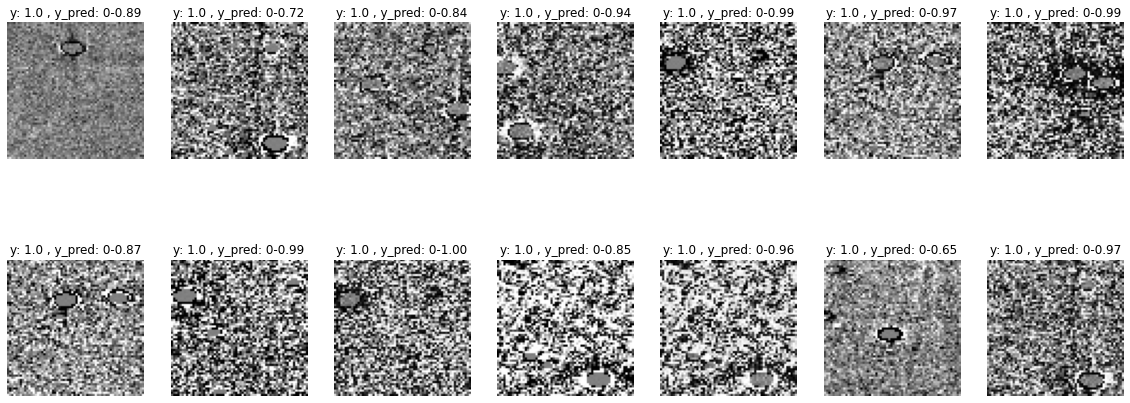

In [411]:
idx_fp = np.where( (y_pred == 0) & (y_test[:,0] == 1) )[0]
col = int( len(idx_fp) / 2 )
fig, axs = pl.subplots(nrows=2, ncols=col, figsize=(20, 8))
axs = axs.ravel()
for i in range( len(axs) ):
    idx = idx_fp[i]
    axs[i].imshow(X_test[ idx, :,:,0], cmap='gray')
    axs[i].axis('off')
    title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
    axs[i].set_title(title)

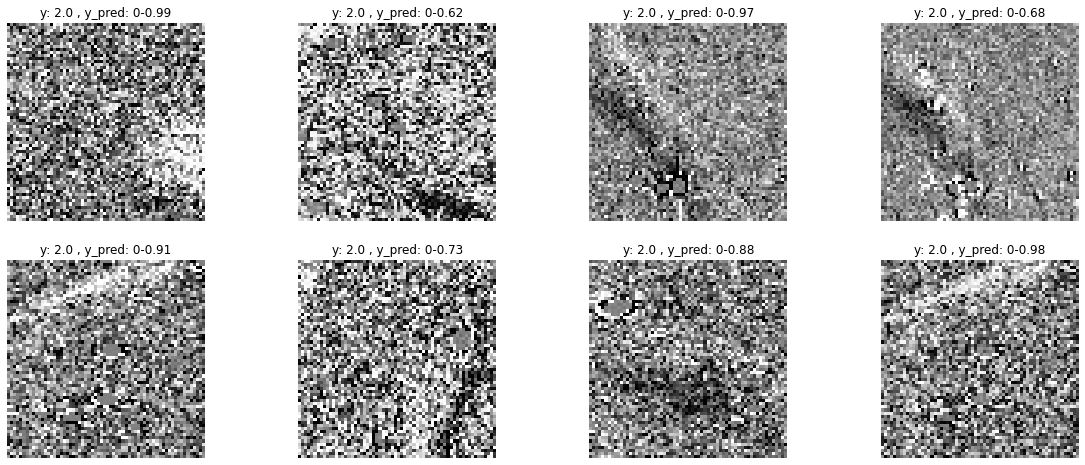

In [412]:
idx_fp = np.where( (y_pred == 0) & (y_test[:,0] == 2) )[0]
col = int( len(idx_fp) / 2 )
fig, axs = pl.subplots(nrows=2, ncols=col, figsize=(20, 8))
axs = axs.ravel()
for i in range( len(axs) ):
    idx = idx_fp[i]
    axs[i].imshow(X_test[ idx, :,:,0], cmap='gray')
    axs[i].axis('off')
    title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
    axs[i].set_title(title)

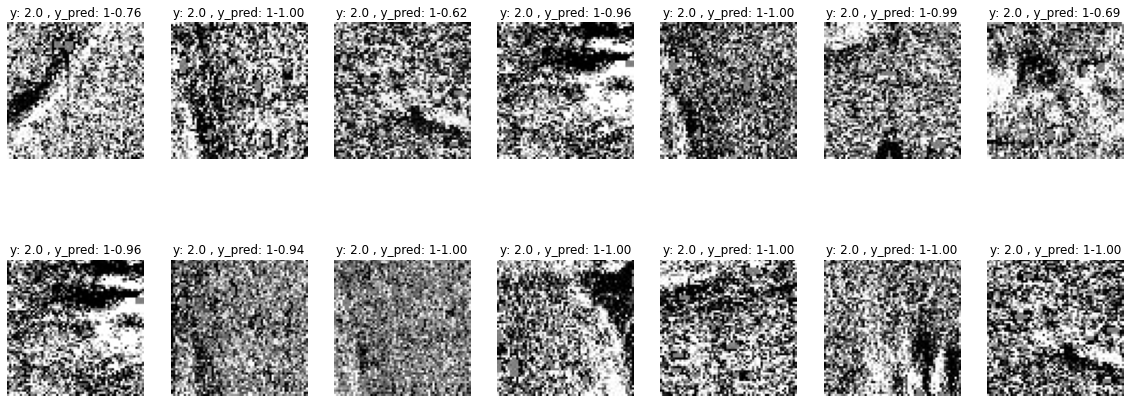

In [413]:
idx_fp = np.where( (y_pred == 1) & (y_test[:,0] == 2) )[0]
col = int( len(idx_fp) / 2 )
fig, axs = pl.subplots(nrows=2, ncols=col, figsize=(20, 8))
axs = axs.ravel()
for i in range( len(axs) ):
    idx = idx_fp[i]
    axs[i].imshow(X_test[ idx, :,:,0], cmap='gray')
    axs[i].axis('off')
    title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
    axs[i].set_title(title)

explore model weight

In [ ]:
plot_filters(model_cnn_k9, 0)
plot_filters(model_cnn_k9, 3)
plot_filters(model_cnn_k9, 6)


In [414]:
model_cnn_k9.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 64, 64, 16)        1312      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 32)        41504     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 64)      

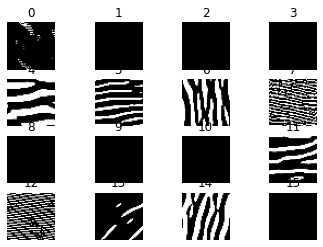

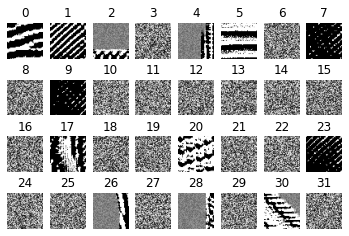

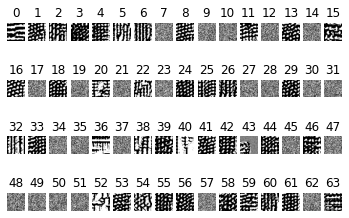

In [416]:
layer_names = ['conv2d_41', 'conv2d_42', 'conv2d_43']
for layer_name in layer_names:
    plot_filterimg(model_cnn_k9, layer_name, it=50, lr=10);

extract features

In [418]:
extractor = keras.Model(inputs=model_cnn_k9.inputs,
                        outputs=[layer.output for layer in model_cnn_k9.layers])


In [ ]:
X.shape

(3654, 64, 64)

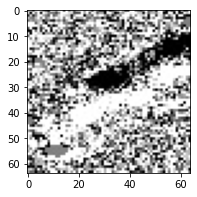

In [419]:
imgidx = 3520
img_ = X[imgidx, :, :]/255
pl.figure(figsize=(3,3))
pl.imshow(img_, cmap='gray')


In [ ]:
Y[imgidx]

array([2.])

In [420]:
# predicted
np.argmax( model_cnn_k9.predict(img_.reshape(1, 64, 64, 1)) )

2

In [421]:
features = extractor(img_.reshape(1, 64, 64, 1 ))


In [ ]:
for i in range( len(features) ):
    print(i, features[i].numpy().shape)

0 (1, 64, 64, 8)
1 (1, 32, 32, 8)
2 (1, 32, 32, 8)
3 (1, 32, 32, 16)
4 (1, 16, 16, 16)
5 (1, 16, 16, 16)
6 (1, 16, 16, 32)
7 (1, 8, 8, 32)
8 (1, 8, 8, 32)
9 (1, 8, 8, 64)
10 (1, 4, 4, 64)
11 (1, 4, 4, 64)
12 (1, 1024)
13 (1, 16)
14 (1, 3)


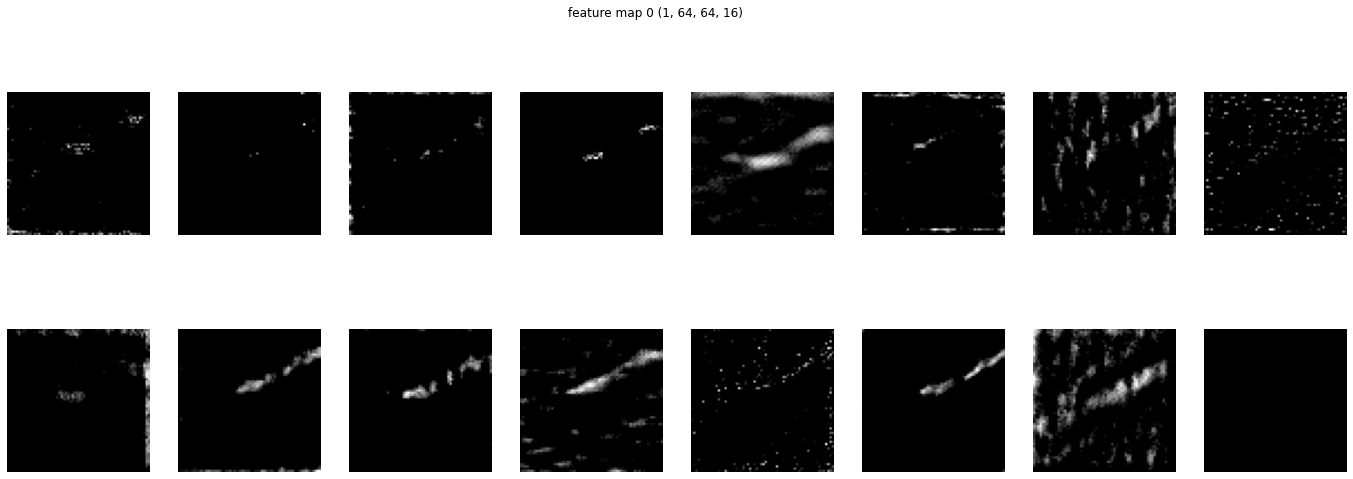

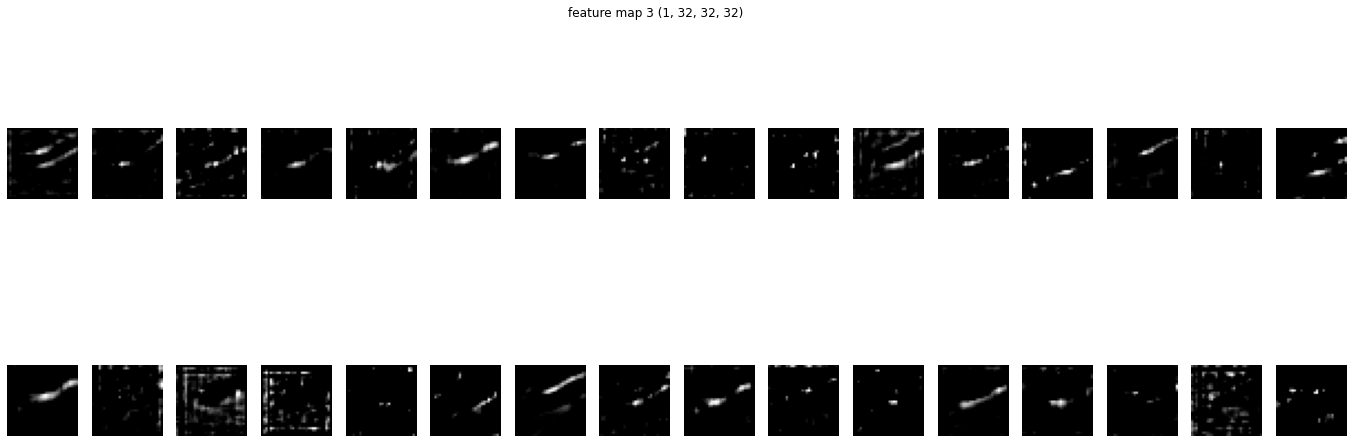

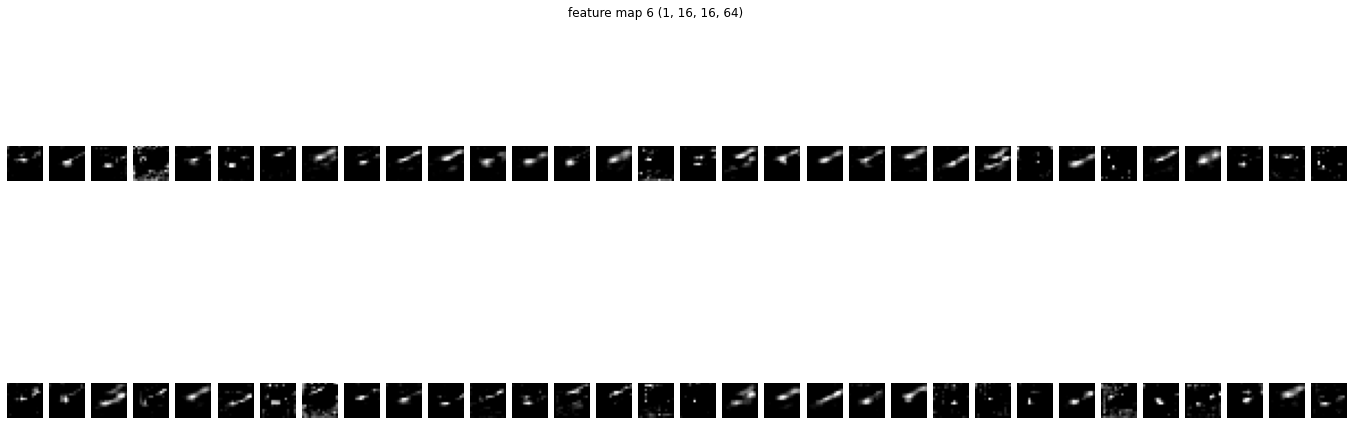

In [422]:
plot_features(layer=0)
plot_features(layer=3)
plot_features(layer=6)


In [ ]:
# keras.utils.plot_model(model_cnn, show_shapes=True, rankdir='TB')

#### Convolutional 2D model , filter size=15

In [ ]:
model_cnn_k15 = create_model(kernel_size=15)

In [ ]:
# keras.utils.plot_model(model_cnn, show_shapes=True, rankdir='TB')

In [429]:
model_cnn_k15.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


In [431]:
history_cnn_k15 = model_cnn_k15.fit(X_train, y_train_onehot, epochs=100, validation_data=(X_val, y_val_onehot))


Epoch 1/100
52/52 [==============================] - 1s 10ms/step - loss: 1.1015 - accuracy: 0.3585 - val_loss: 1.0922 - val_accuracy: 0.3899
Epoch 2/100
52/52 [==============================] - 0s 8ms/step - loss: 1.0902 - accuracy: 0.3817 - val_loss: 1.0649 - val_accuracy: 0.3973
Epoch 3/100
52/52 [==============================] - 0s 8ms/step - loss: 1.0284 - accuracy: 0.4366 - val_loss: 0.9866 - val_accuracy: 0.5111
Epoch 4/100
52/52 [==============================] - 0s 8ms/step - loss: 0.9390 - accuracy: 0.5250 - val_loss: 0.8857 - val_accuracy: 0.5557
Epoch 5/100
52/52 [==============================] - 0s 8ms/step - loss: 0.8806 - accuracy: 0.5762 - val_loss: 0.8436 - val_accuracy: 0.6052
Epoch 6/100
52/52 [==============================] - 0s 7ms/step - loss: 0.8634 - accuracy: 0.5878 - val_loss: 0.8378 - val_accuracy: 0.6002
Epoch 7/100
52/52 [==============================] - 0s 8ms/step - loss: 0.7941 - accuracy: 0.6165 - val_loss: 0.7519 - val_accuracy: 0.6683
Epoch 8/100


In [432]:
# evaulate model
test_loss, test_acc = model_cnn_k9.evaluate(X_test, y_test_onehot)


38/38 [==============================] - 0s 3ms/step - loss: 0.1799 - accuracy: 0.9726


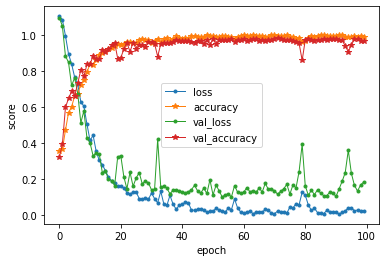

In [ ]:
plot_score(history_cnn_k9)

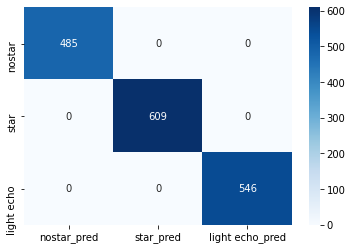

In [434]:
plot_cm(model_cnn_k15, X_train, y_train)

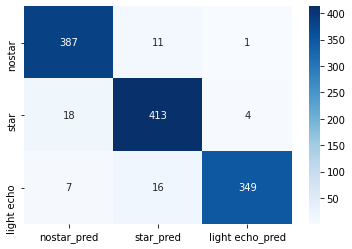

In [435]:
plot_cm(model_cnn_k15, X_test, y_test)

In [ ]:
# get false positive 
y_pred_prob = model_cnn_k9.predict(X_test)
y_pred = np.argmax( y_pred_prob, axis=1)
y_pred_prob = np.max( y_pred_prob, axis=1)


Text(0.5, 1.0, 'y: 1.0 , y_pred: 2-1.00')

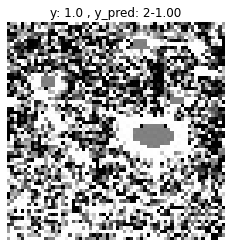

In [ ]:
idx_fp = np.where( (y_pred == 2) & (y_test[:,0] == 1) )[0]
idx = idx_fp[0]
pl.imshow(X_test[ idx, :,:,0], cmap='gray')
pl.axis('off')
title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
pl.title(title)

Text(0.5, 1.0, 'y: 2.0 , y_pred: 1-0.89')

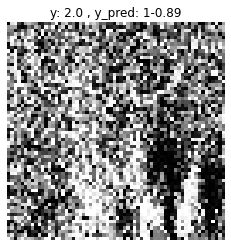

In [ ]:
idx_fp = np.where( (y_pred == 1) & (y_test[:,0] == 2) )[0]
idx = idx_fp[0]
pl.imshow(X_test[ idx, :,:,0], cmap='gray')
pl.axis('off')
title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
pl.title(title)

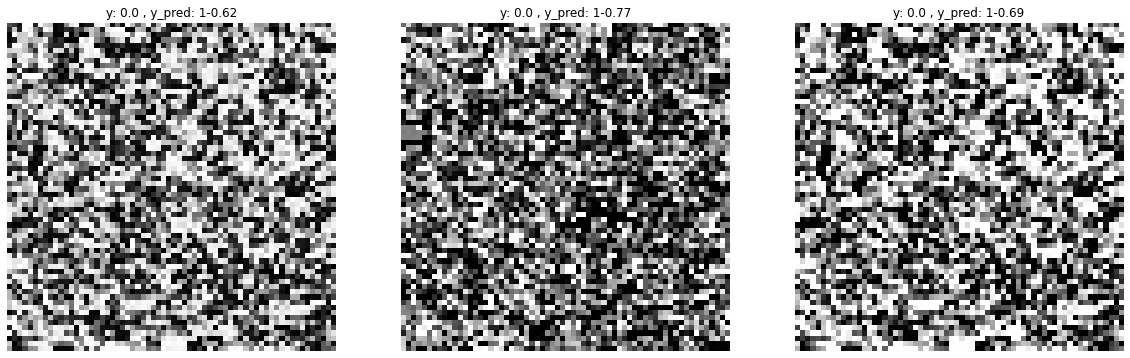

In [ ]:
idx_fp = np.where( (y_pred == 1) & (y_test[:,0] == 0) )[0]
col = int( len(idx_fp) )
fig, axs = pl.subplots(nrows=1, ncols=col, figsize=(20, 8))
axs = axs.ravel()
for i in range( len(axs) ):
    idx = idx_fp[i]
    axs[i].imshow(X_test[ idx, :,:,0], cmap='gray')
    axs[i].axis('off')
    title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
    axs[i].set_title(title)

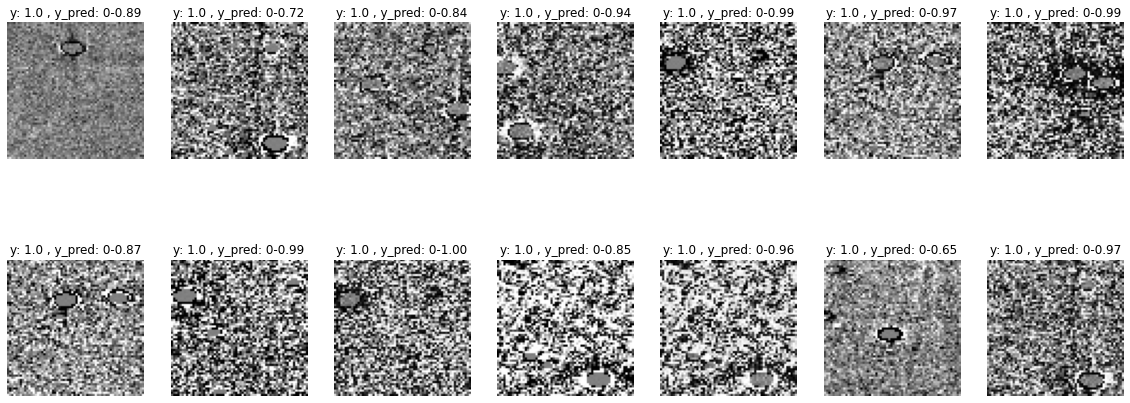

In [ ]:
idx_fp = np.where( (y_pred == 0) & (y_test[:,0] == 1) )[0]
col = int( len(idx_fp) / 2 )
fig, axs = pl.subplots(nrows=2, ncols=col, figsize=(20, 8))
axs = axs.ravel()
for i in range( len(axs) ):
    idx = idx_fp[i]
    axs[i].imshow(X_test[ idx, :,:,0], cmap='gray')
    axs[i].axis('off')
    title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
    axs[i].set_title(title)

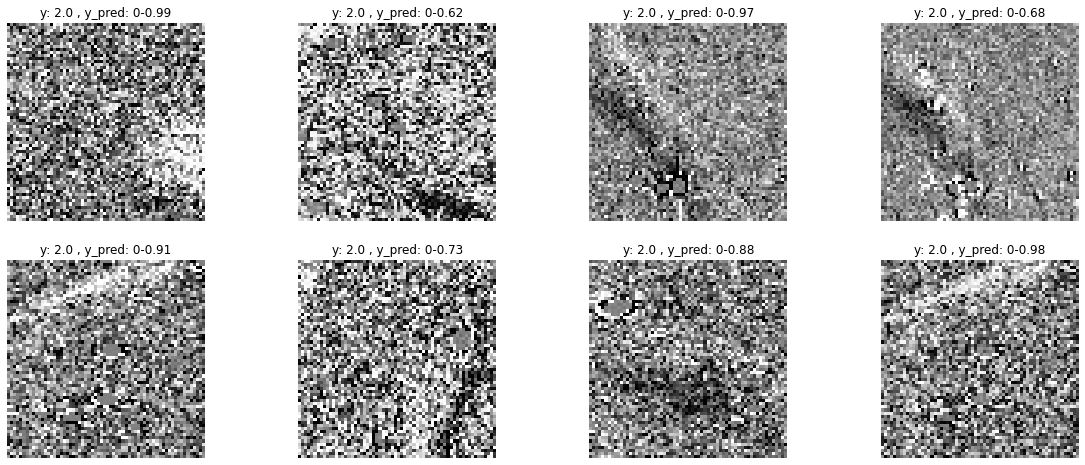

In [ ]:
idx_fp = np.where( (y_pred == 0) & (y_test[:,0] == 2) )[0]
col = int( len(idx_fp) / 2 )
fig, axs = pl.subplots(nrows=2, ncols=col, figsize=(20, 8))
axs = axs.ravel()
for i in range( len(axs) ):
    idx = idx_fp[i]
    axs[i].imshow(X_test[ idx, :,:,0], cmap='gray')
    axs[i].axis('off')
    title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
    axs[i].set_title(title)

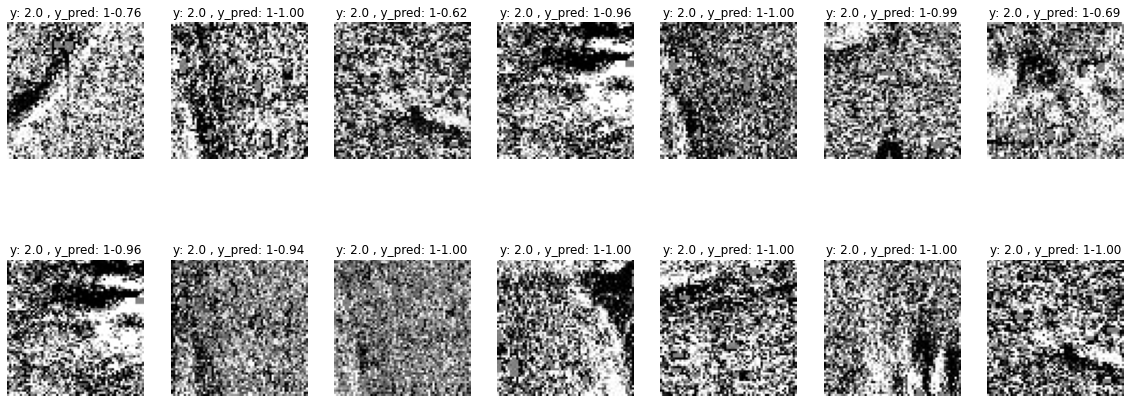

In [ ]:
idx_fp = np.where( (y_pred == 1) & (y_test[:,0] == 2) )[0]
col = int( len(idx_fp) / 2 )
fig, axs = pl.subplots(nrows=2, ncols=col, figsize=(20, 8))
axs = axs.ravel()
for i in range( len(axs) ):
    idx = idx_fp[i]
    axs[i].imshow(X_test[ idx, :,:,0], cmap='gray')
    axs[i].axis('off')
    title = "y: {} , y_pred: {}-{:.2f}".format(y_test[idx].item(), y_pred[idx], y_pred_prob[idx])
    axs[i].set_title(title)

explore model weight

In [ ]:
plot_filters(model_cnn_k9, 0)
plot_filters(model_cnn_k9, 3)
plot_filters(model_cnn_k9, 6)


In [436]:
model_cnn_k15.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 64, 64, 16)        3616      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 32)        115232    
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 16, 16, 64)      

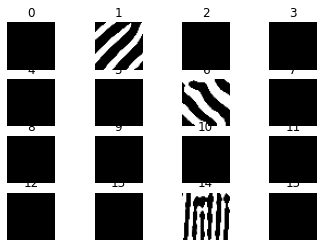

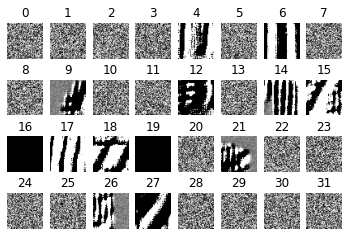

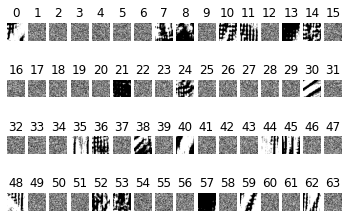

In [437]:
layer_names = ['conv2d_44', 'conv2d_45', 'conv2d_46']
for layer_name in layer_names:
    plot_filterimg(model_cnn_k15, layer_name, it=50, lr=10);

extract features

In [ ]:
extractor = keras.Model(inputs=model_cnn_k9.inputs,
                        outputs=[layer.output for layer in model_cnn_k9.layers])


In [ ]:
X.shape

(3654, 64, 64)

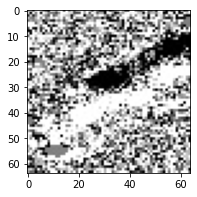

In [ ]:
imgidx = 3520
img_ = X[imgidx, :, :]/255
pl.figure(figsize=(3,3))
pl.imshow(img_, cmap='gray')


In [ ]:
Y[imgidx]

array([2.])

In [ ]:
# predicted
np.argmax( model_cnn_k9.predict(img_.reshape(1, 64, 64, 1)) )

2

In [ ]:
features = extractor(img_.reshape(1, 64, 64, 1 ))


In [ ]:
for i in range( len(features) ):
    print(i, features[i].numpy().shape)

0 (1, 64, 64, 8)
1 (1, 32, 32, 8)
2 (1, 32, 32, 8)
3 (1, 32, 32, 16)
4 (1, 16, 16, 16)
5 (1, 16, 16, 16)
6 (1, 16, 16, 32)
7 (1, 8, 8, 32)
8 (1, 8, 8, 32)
9 (1, 8, 8, 64)
10 (1, 4, 4, 64)
11 (1, 4, 4, 64)
12 (1, 1024)
13 (1, 16)
14 (1, 3)


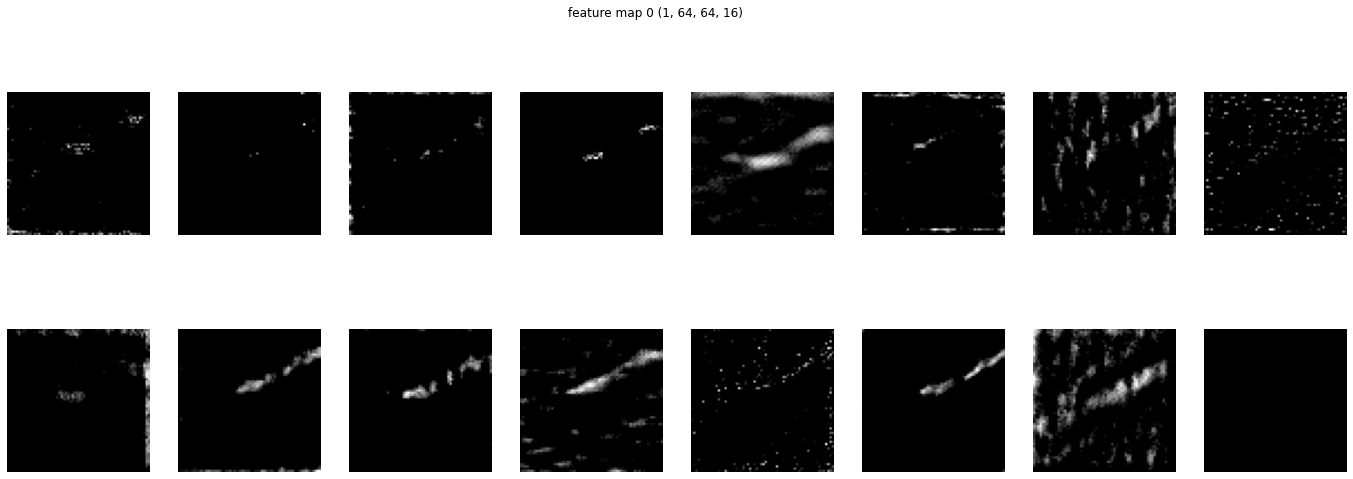

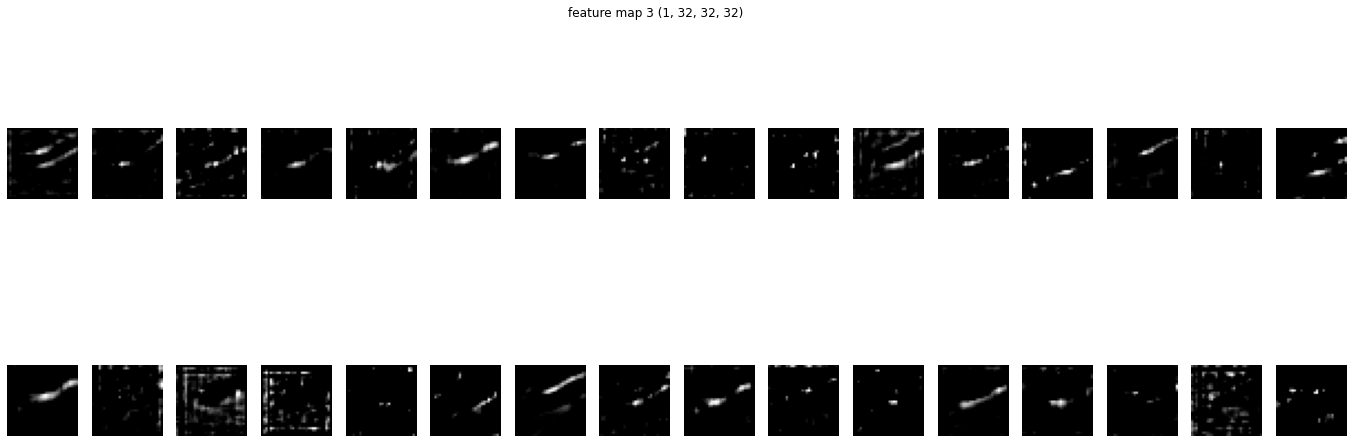

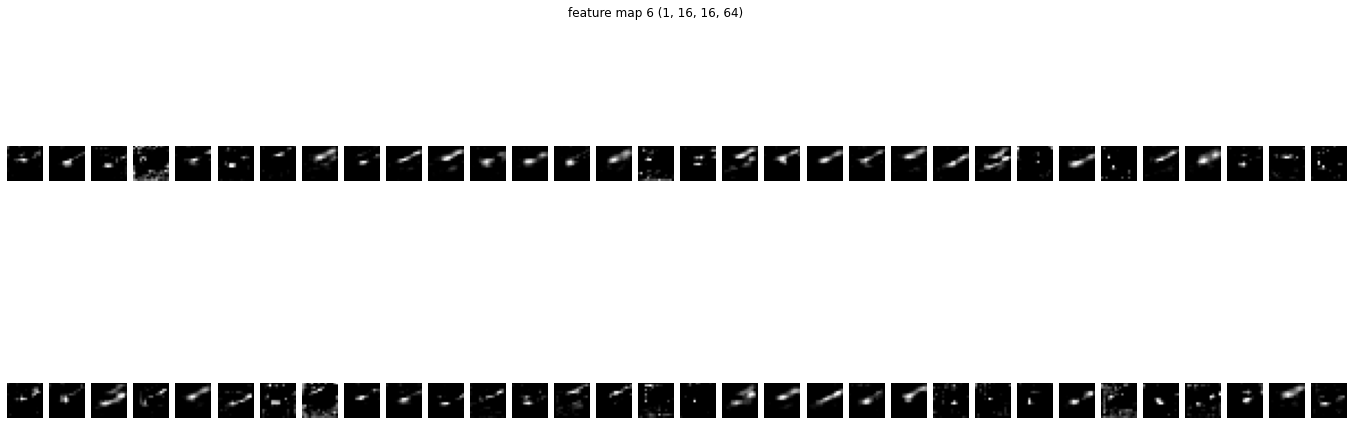

In [ ]:
plot_features(layer=0)
plot_features(layer=3)
plot_features(layer=6)


In [ ]:
# keras.utils.plot_model(model_cnn, show_shapes=True, rankdir='TB')

#### others

predict some GAN generated images

In [423]:
LE_gan = cv2.imread( 'star64/LEs_gan/generated_LE_2_566.png' )

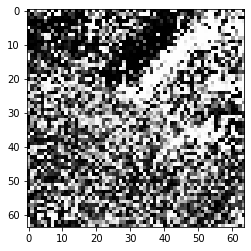

In [424]:
LE_gan = LE_gan / 255
pl.imshow(LE_gan, cmap='gray')

In [ ]:
LE_gan.shape

(64, 64, 3)

In [425]:
LE_gan_pred = model_cnn_k9.predict(LE_gan[:,:, 0].reshape(1, 64, 64, 1))
np.argmax(LE_gan_pred)

2

Text(0.5, 1.0, '2')

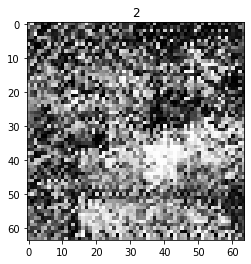

In [427]:
imgfile = 'star64/LEs_gan/generated_LE_2_63.png'
LE_gan = cv2.imread( imgfile ) / 255
LE_gan_pred = model_cnn.predict(LE_gan[:,:, 0].reshape(1, 64, 64, 1))

pl.imshow(LE_gan)
pl.title( np.argmax(LE_gan_pred) )


### GRAD- CAM

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap



In [ ]:
img_path = 'star64/LEs_gan/generated_LE_2_566.png'
img_size = (64, 64)

In [ ]:
preprocess_input = keras.applications.xception.preprocess_input


In [ ]:
img_array.shape

(1, 64, 64, 3)

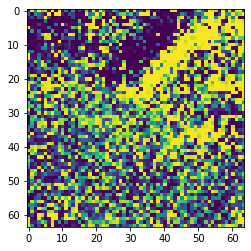

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

pl.imshow(img_array[0, :, :, 0], cmap='gray')
# Make model
# model = model_builder(weights="imagenet")


In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

In [ ]:
last_conv_layer_name = "dropout_3"
classifier_layer_names = [
    "flatten",
    "dense",
    "dense_1"
]


In [ ]:
imgarr = img_array[:, :, :, 0].reshape(1, 64, 64, 1)

In [ ]:
# Print what the top predicted class is
preds = model_cnn.predict(imgarr)
print("Predicted:", np.argmax(preds) )


Predicted: 2


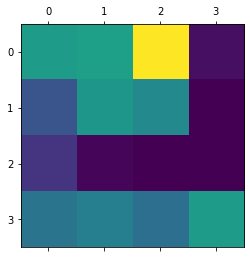

In [ ]:


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    imgarr, model_cnn, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
pl.matshow(heatmap)
pl.show()

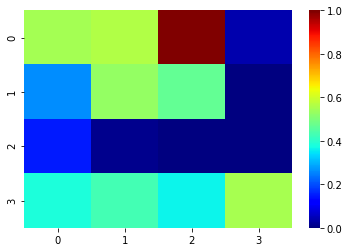

In [ ]:
sn.heatmap(heatmap, cmap='jet')

In [ ]:
from skimage.transform import rescale

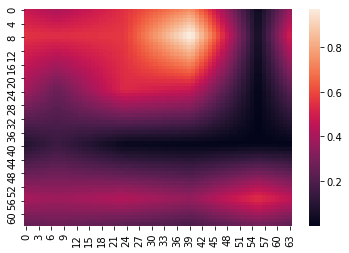

In [ ]:
heatmap64 = rescale(heatmap, 16)
sn.heatmap(heatmap64)

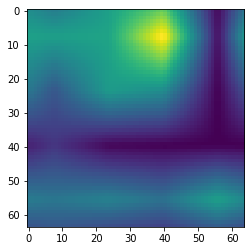

In [ ]:
pl.imshow(heatmap64)

In [ ]:
imgarr[0, :,:,0].shape

(64, 64)

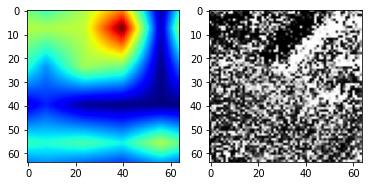

In [ ]:
imgLE = imgarr[0, :,:,0]

fig, axs = pl.subplots(1, 2)
axs[0].imshow(heatmap64,  cmap='jet')
axs[1].imshow(imgLE, cmap='gray')

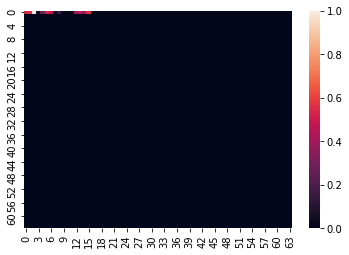

In [ ]:
sn.heatmap( heatmap )

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = pl.cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)


In [ ]:
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img.shape

(64, 64, 3)

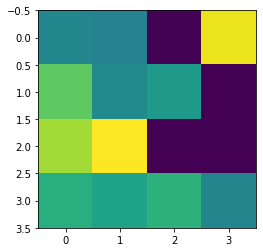

In [ ]:
pl.imshow(heatmap)